In [1]:
import spacy
from collections import Counter
from gensim.utils import simple_preprocess
from multiprocessing import Pool
from preprocessing_utils import preprocess_document_for_count

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import ParameterGrid

import datautils
import json
import pandas as pd

In [2]:
PATH = "./Dataset/power-gb-train.tsv"
RES_DIR = "./Results/"
EMBED_DIR = "./Embeddings/"

# Auxiliar functions

## Documents Preprocessing

In [ ]:
# Returns the text in a list of tokens after preprocessing
def preprocess_text(text, nlp):
    doc = nlp(text)
    processed_tokens = [token.text for token in doc if token.text.lower()]
    return processed_tokens


# Returns the dataset in a json format (list of lists of tokens)
def preprocess_training_set(training_set, output_path, nlp):
    preprocessed_training_set = []
    i = 0
    for text in training_set:
        preprocessed_text = preprocess_text(text, nlp)
        preprocessed_training_set.append(preprocessed_text)
    with open(output_path, "w", encoding="utf-8") as outfile:
        json.dump(
            preprocessed_training_set, outfile, ensure_ascii=False, indent=4
        )


nlp1 = spacy.load("en_core_web_sm")

# uncomment to abtain preprocessed datasets for medium and large models
# nlp2 = spacy.load("en_core_web_md")
# nlp3 = spacy.load("en_core_web_lg")

X_train, y_train, X_val, y_val, _, _ = datautils.split_holdout_dataset(PATH)

preprocess_training_set(X_train, "preprocessed_training_setsm.json", nlp1)

# uncomment to abtain preprocessed datasets for medium and large models
# preprocess_training_set(X_train, "preprocessed_training_setmd.json", nlp2)
# preprocess_training_set(X_train, "preprocessed_training_setlg.json", nlp3)

## Rare Words Detection

In [ ]:
def write_rare_words_to_file(rare_words, filename):
    with open(filename, "w", encoding="utf-8") as file:
        for word in rare_words:
            file.write(word + "\n")


def detect_rare_words(documents, num_processes=8):
    # Run the preprocessing of the documents
    with Pool(num_processes) as pool:
        tokens_lists = pool.map(preprocess_document_for_count, documents)

    # Count the word frequency
    word_freq = Counter(word for tokens in tokens_lists for word in tokens)
    # Find the rare words
    rare_words1 = set(word for word, freq in word_freq.items() if freq < 10)
    rare_words2 = set(word for word, freq in word_freq.items() if freq < 100)
    rare_words3 = set(word for word, freq in word_freq.items() if freq < 1000)
    write_rare_words_to_file(rare_words1, "rare_words10.txt")
    write_rare_words_to_file(rare_words2, "rare_words100.txt")
    write_rare_words_to_file(rare_words3, "rare_words1000.txt")
    return word_freq


detect_rare_words(X_train, num_processes=8)

## Dataset Loading Utilities

In [6]:
def load_preprocessed_training_set(input_path):
    with open(input_path, "r", encoding="utf-8") as file:
        preprocessed_training_set = json.load(file)
    return preprocessed_training_set


def join_tokens(tokens):
    return " ".join(tokens)


def join_texts(preprocessed_training_set):
    return [join_tokens(tokens) for tokens in preprocessed_training_set]


def read_file_words(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        parole = [line.strip() for line in file]
    return parole


def remove_words(testo, word_to_exclude):
    parole_testo = testo.split()
    parole_filtrate = [
        parola for parola in parole_testo if parola not in word_to_exclude
    ]
    testo_filtrato = " ".join(parole_filtrate)
    return testo_filtrato


def remove_stopwords(text, stopwords):
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stopwords]
    return " ".join(filtered_tokens)

# Random forest on different pretrainings

To do the full grid search execute the following cell

In [ ]:
"""
for pipe in ["sm","md",'lg']:
    print("Analyzing pipe: " + pipe)
    input_path = "preprocessed_training_set" + pipe + ".json"
    nlp = spacy.load("en_core_web_" + pipe)
    stop_words = spacy.lang.en.stop_words.STOP_WORDS
    # Rebuilt the training set
    for tresh in ["10","100","1000"]:
        preprocessed_training_set = load_preprocessed_training_set(input_path)
        X_train = join_texts(preprocessed_training_set)
        print("Analyzing treshold: " + tresh)
        file_word_to_exclude = "rare_words" + tresh + ".txt"
        word_to_exclude = read_file_words(file_word_to_exclude)

        # Vettore di testi
        vettore_testi = X_train
        X_train = [
            remove_words(testo, word_to_exclude) for testo in vettore_testi
        ]
        X_train = [remove_stopwords(text, stop_words) for text in X_train]

        # TFIDF Vectorization
        X_train, vectorizer = datautils.tf_idf_preprocessing(X_train)
        _, y_train, X_val, y_val, _, _ = datautils.split_holdout_dataset(PATH)
        X_val = vectorizer.transform(X_val)

        hyperparameters = {
            "n_estimators": [1000,2000],
            "max_depth": [10,25,50],
            "min_samples_split": [3,5],
            "min_samples_leaf": [2,3],
        }

        param_grid = list(ParameterGrid(hyperparameters))

        results = pd.DataFrame(
            columns=[
                "n_estimators",
                "max_depth",
                "min_samples_split",
                "min_samples_leaf",
                "precision",
                "recall",
                "fscore",
                "p_train",
                "r_train",
                "f_train",
            ]
        )

        # train random forest
        for par in param_grid:
            print(par)
            rf = RandomForestClassifier(
                n_estimators=par["n_estimators"],
                max_depth=par["max_depth"],
                min_samples_split=par["min_samples_split"],
                min_samples_leaf=par["min_samples_leaf"],
                n_jobs=-1,
            )
            print(par)
            rf.fit(X_train, y_train)

            y_pred = rf.predict(X_val)

            # compute metrics on training set
            p_train, r_train, f_train, _ = precision_recall_fscore_support(
                y_train, rf.predict(X_train), average="macro"
            )
            # compute metrics on test set
            precision, recall, fscore, _ = precision_recall_fscore_support(
                y_val, y_pred, average="macro"
            )

            print(f"VAL fscore: {fscore:.4f}, TRain fscore: {f_train:.4f}")
            results = pd.concat(
                [
                    results,
                    pd.DataFrame(
                        {
                            "n_estimators": [par["n_estimators"]],
                            "max_depth": [par["max_depth"]],
                            "min_samples_split": [par["min_samples_split"]],
                            "min_samples_leaf": [par["min_samples_leaf"]],
                            "precision": [precision],
                            "recall": [recall],
                            "fscore": [fscore],
                            "p_train": [p_train],
                            "r_train": [r_train],
                            "f_train": [f_train],
                        }
                    ),
                ]
            )

        results.to_csv(RES_DIR + "rfstop" + tresh + pipe + ".csv", index=False)

"""

To obtain only the best model executed the following cell

In [7]:
for pipe in ["sm"]:
    print("Analyzing pipe: " + pipe)
    input_path = "preprocessed_training_set" + pipe + ".json"
    nlp = spacy.load("en_core_web_" + pipe)
    stop_words = spacy.lang.en.stop_words.STOP_WORDS
    # Rebuilt the training set
    for tresh in ["1000"]:
        preprocessed_training_set = load_preprocessed_training_set(input_path)
        X_train = join_texts(preprocessed_training_set)
        print("Analyzing treshold: " + tresh)
        file_word_to_exclude = "rare_words" + tresh + ".txt"
        word_to_exclude = read_file_words(file_word_to_exclude)

        # Vettore di testi
        vettore_testi = X_train
        X_train = [
            remove_words(testo, word_to_exclude) for testo in vettore_testi
        ]
        X_train = [remove_stopwords(text, stop_words) for text in X_train]

        # TFIDF Vectorization
        X_train, vectorizer = datautils.tf_idf_preprocessing(X_train)
        _, y_train, X_val, y_val, _, _ = datautils.split_holdout_dataset(PATH)
        X_val = vectorizer.transform(X_val)

        hyperparameters = {
            "n_estimators": [1000],
            "max_depth": [50],
            "min_samples_split": [3],
            "min_samples_leaf": [2],
        }

        param_grid = list(ParameterGrid(hyperparameters))

        results = pd.DataFrame(
            columns=[
                "n_estimators",
                "max_depth",
                "min_samples_split",
                "min_samples_leaf",
                "precision",
                "recall",
                "fscore",
                "p_train",
                "r_train",
                "f_train",
            ]
        )

        # train random forest
        for par in param_grid:
            print(par)
            rf = RandomForestClassifier(
                n_estimators=par["n_estimators"],
                max_depth=par["max_depth"],
                min_samples_split=par["min_samples_split"],
                min_samples_leaf=par["min_samples_leaf"],
                n_jobs=-1,
            )
            print(par)
            rf.fit(X_train, y_train)

            y_pred = rf.predict(X_val)

            # compute metrics on training set
            p_train, r_train, f_train, _ = precision_recall_fscore_support(
                y_train, rf.predict(X_train), average="macro"
            )
            # compute metrics on test set
            precision, recall, fscore, _ = precision_recall_fscore_support(
                y_val, y_pred, average="macro"
            )

            print(f"VAL fscore: {fscore:.4f}, TRain fscore: {f_train:.4f}")
            results = pd.concat(
                [
                    results,
                    pd.DataFrame(
                        {
                            "n_estimators": [par["n_estimators"]],
                            "max_depth": [par["max_depth"]],
                            "min_samples_split": [par["min_samples_split"]],
                            "min_samples_leaf": [par["min_samples_leaf"]],
                            "precision": [precision],
                            "recall": [recall],
                            "fscore": [fscore],
                            "p_train": [p_train],
                            "r_train": [r_train],
                            "f_train": [f_train],
                        }
                    ),
                ]
            )

        # results.to_csv(RES_DIR + "rfstop" + tresh + pipe + ".csv", index=False)

Analyzing pipe: sm
Analyzing treshold: 1000
{'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 1000}
{'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 1000}
VAL fscore: 0.7364, TRain fscore: 0.9840


/var/folders/7r/qvcjkyfd0k59hjv_yfvc3hj00000gn/T/ipykernel_48148/1387276287.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat(


Best model evaluation on test set

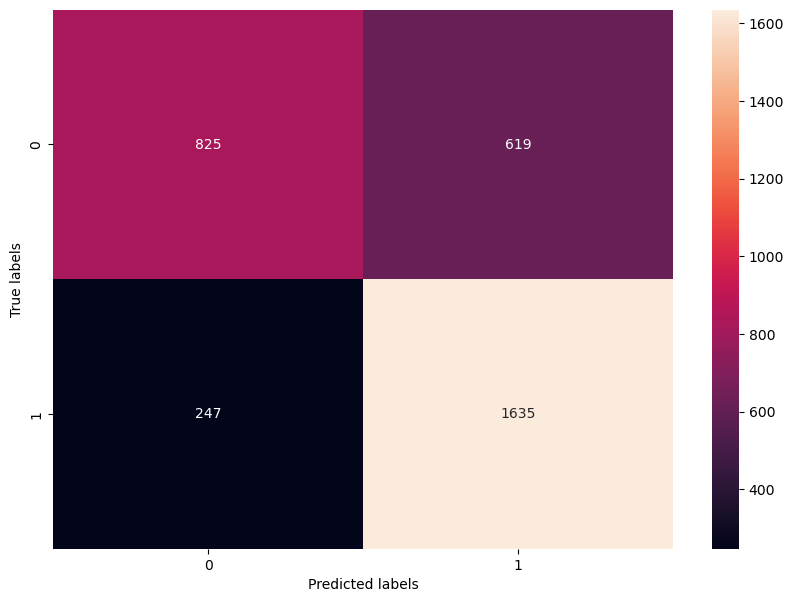

In [9]:
_, _, _, _, X_test, y_test = datautils.split_holdout_dataset(PATH)
X_test = vectorizer.transform(X_test)
y_pred = rf.predict(X_test)

# Now we want to build the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

In [10]:
conf_matrix

array([[ 825,  619],
       [ 247, 1635]])